In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
from sklearn.datasets import make_moons
from src.utils.data import add_noise

def make_moons_random_assignment(n_samples, n_swap=0, seed=0):
    np.random.seed(seed)
    X, l = make_moons(n_samples=n_samples, random_state=seed, noise=0.0)
    # X, l = add_noise(X, l, 20, 0.1)
    class0 = np.where(l == 0)[0]
    class1 = np.where(l == 1)[0]
    choice_class0 = np.random.choice(len(class0), replace=False, size=n_samples // 100 * n_swap)
    choice_class1 = np.random.choice(len(class1), replace=False, size=n_samples // 100 * n_swap)
    l[class0[choice_class0]] = 1
    l[class1[choice_class1]] = 0
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
n_swaps = range(0, 26)
twoMoons_datasets = [
    [make_moons_random_assignment(500, n_swap=n_swap, seed=seed) for seed in random_seeds]
    for n_swap in n_swaps
]

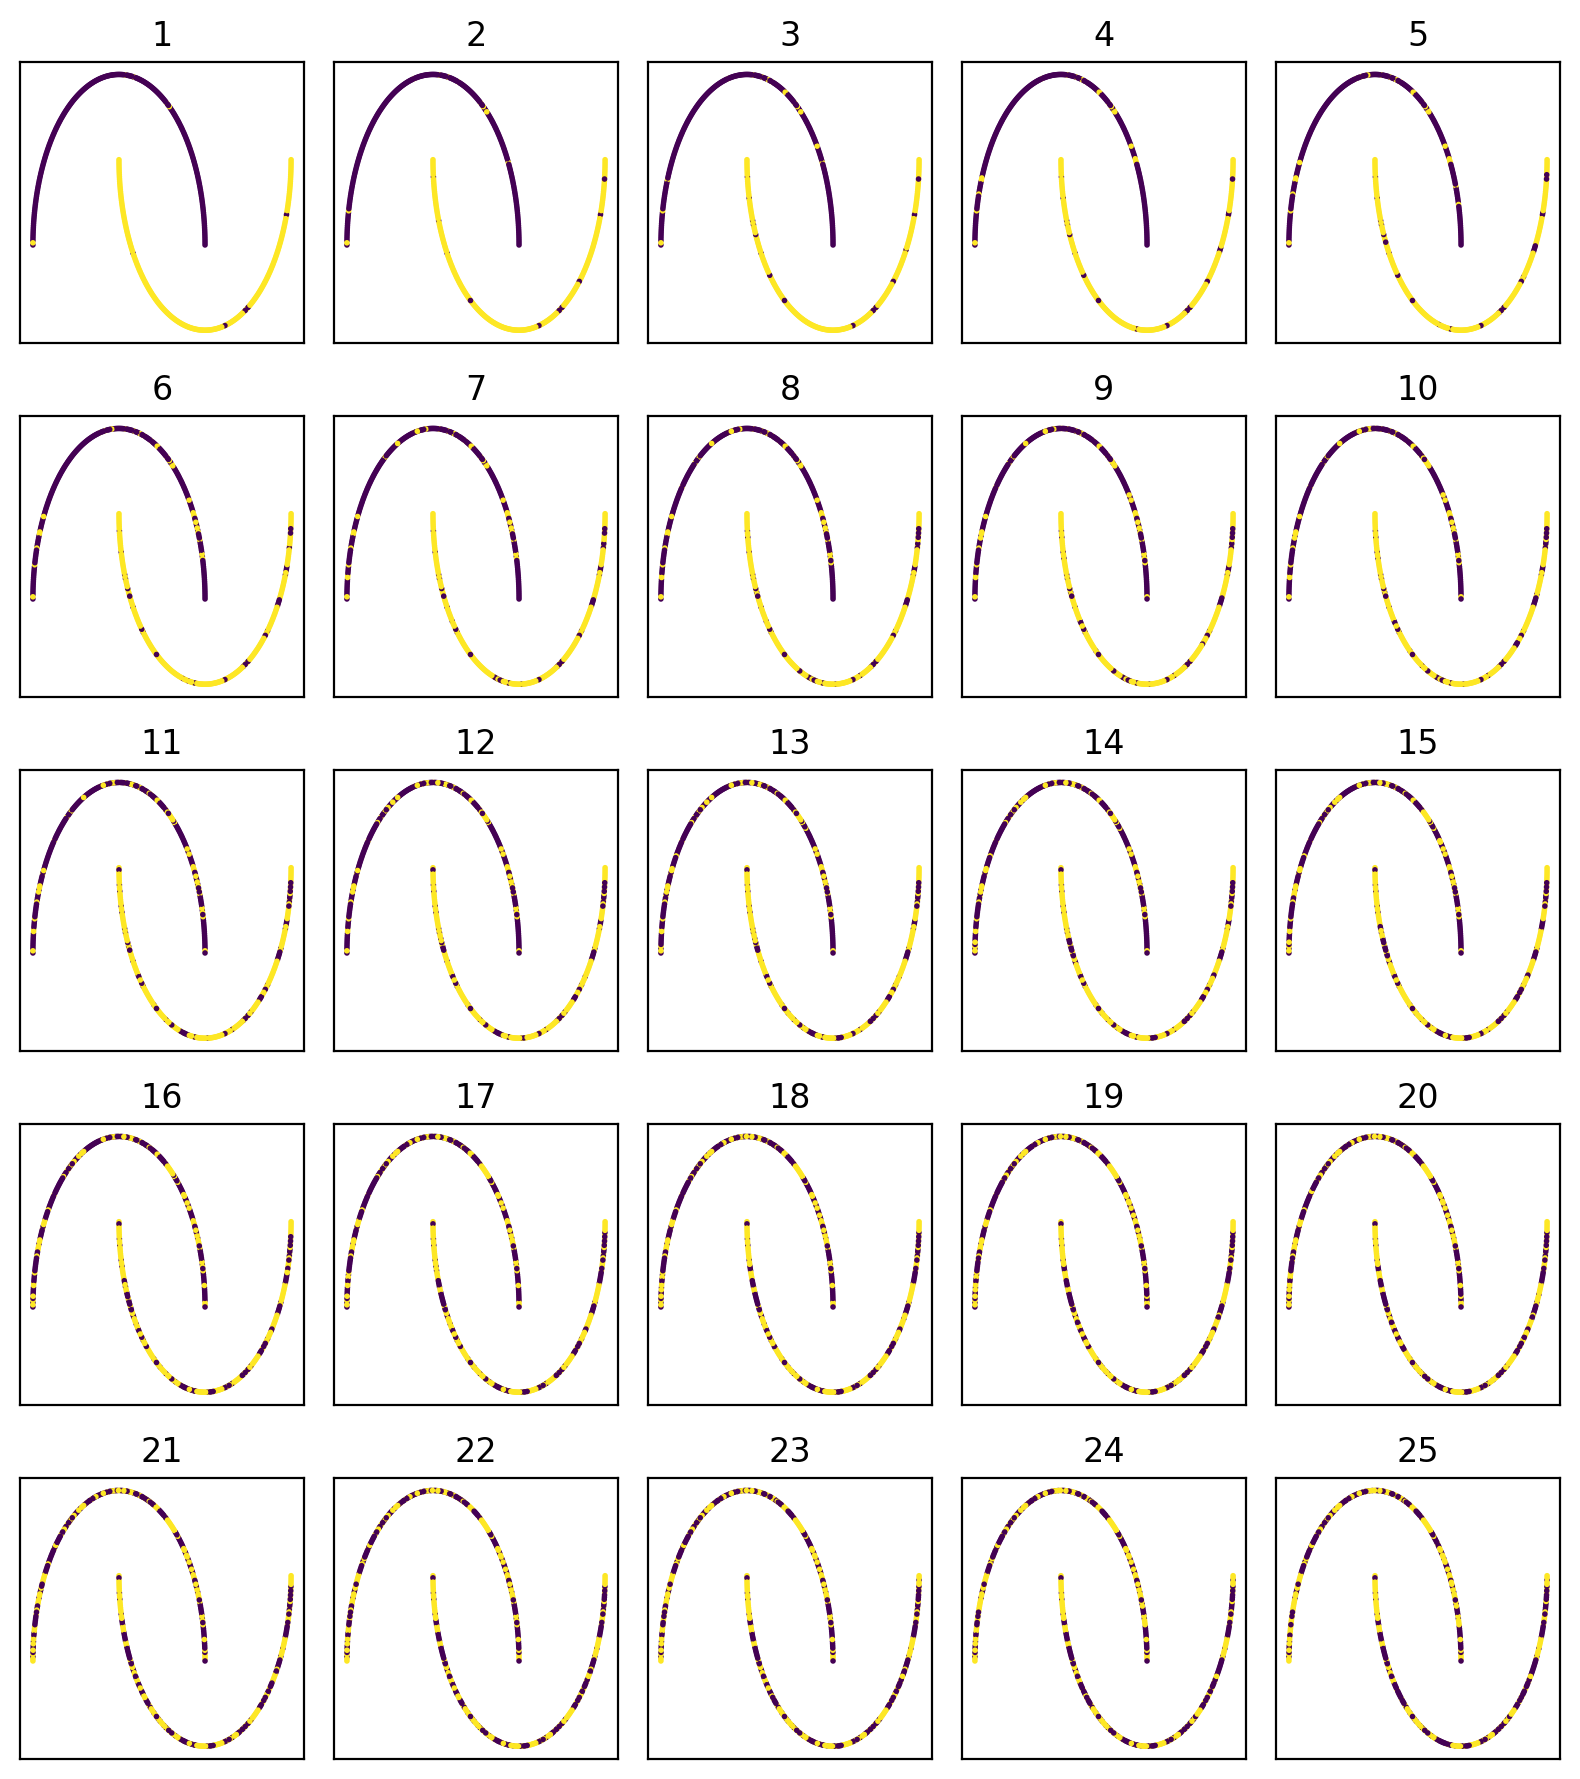

In [6]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets

plot_datasets(twoMoons_datasets[1:], n_swaps[1:], n_cols=5, figsize=1.6)
plt.savefig("imgs/TwoMoons_nswap_data.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

In [8]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, SELECTED_METRICS

selected_metrics = SELECTED_METRICS.copy()

eval_results = cache(
    "TwoMoons_nswap",
    calc_eval_measures_for_multiple_datasets,
    [twoMoons_datasets, n_swaps],
    recalc=False,
)

selected_metrics.remove("S_DBW")
selected_metrics.remove("CVNN")

df = create_and_rescale_df(eval_results, selected_metrics=selected_metrics)

In [9]:
# import pandas as pd
# df_nonscaled = pd.DataFrame(eval_results)

# df_nonscaled.groupby(["dataset", "measure"]).value.mean().to_latex("latex/two_moons_wrongly_labeled_densities.tex")
# df_nonscaled.groupby(["dataset", "measure"]).value.mean().groupby("measure").mean().to_latex(
#     "latex/two_moons_wrongly_labeled_densities_mean.tex"
# )
# df_nonscaled.groupby(["dataset", "measure"]).value.mean().groupby("measure").min().to_latex(
#     "latex/two_moons_wrongly_labeled_densities_min.tex"
# )
# df_nonscaled.groupby(["dataset", "measure"]).value.mean().groupby("measure").max().to_latex(
#     "latex/two_moons_wrongly_labeled_densities_max.tex"
# )

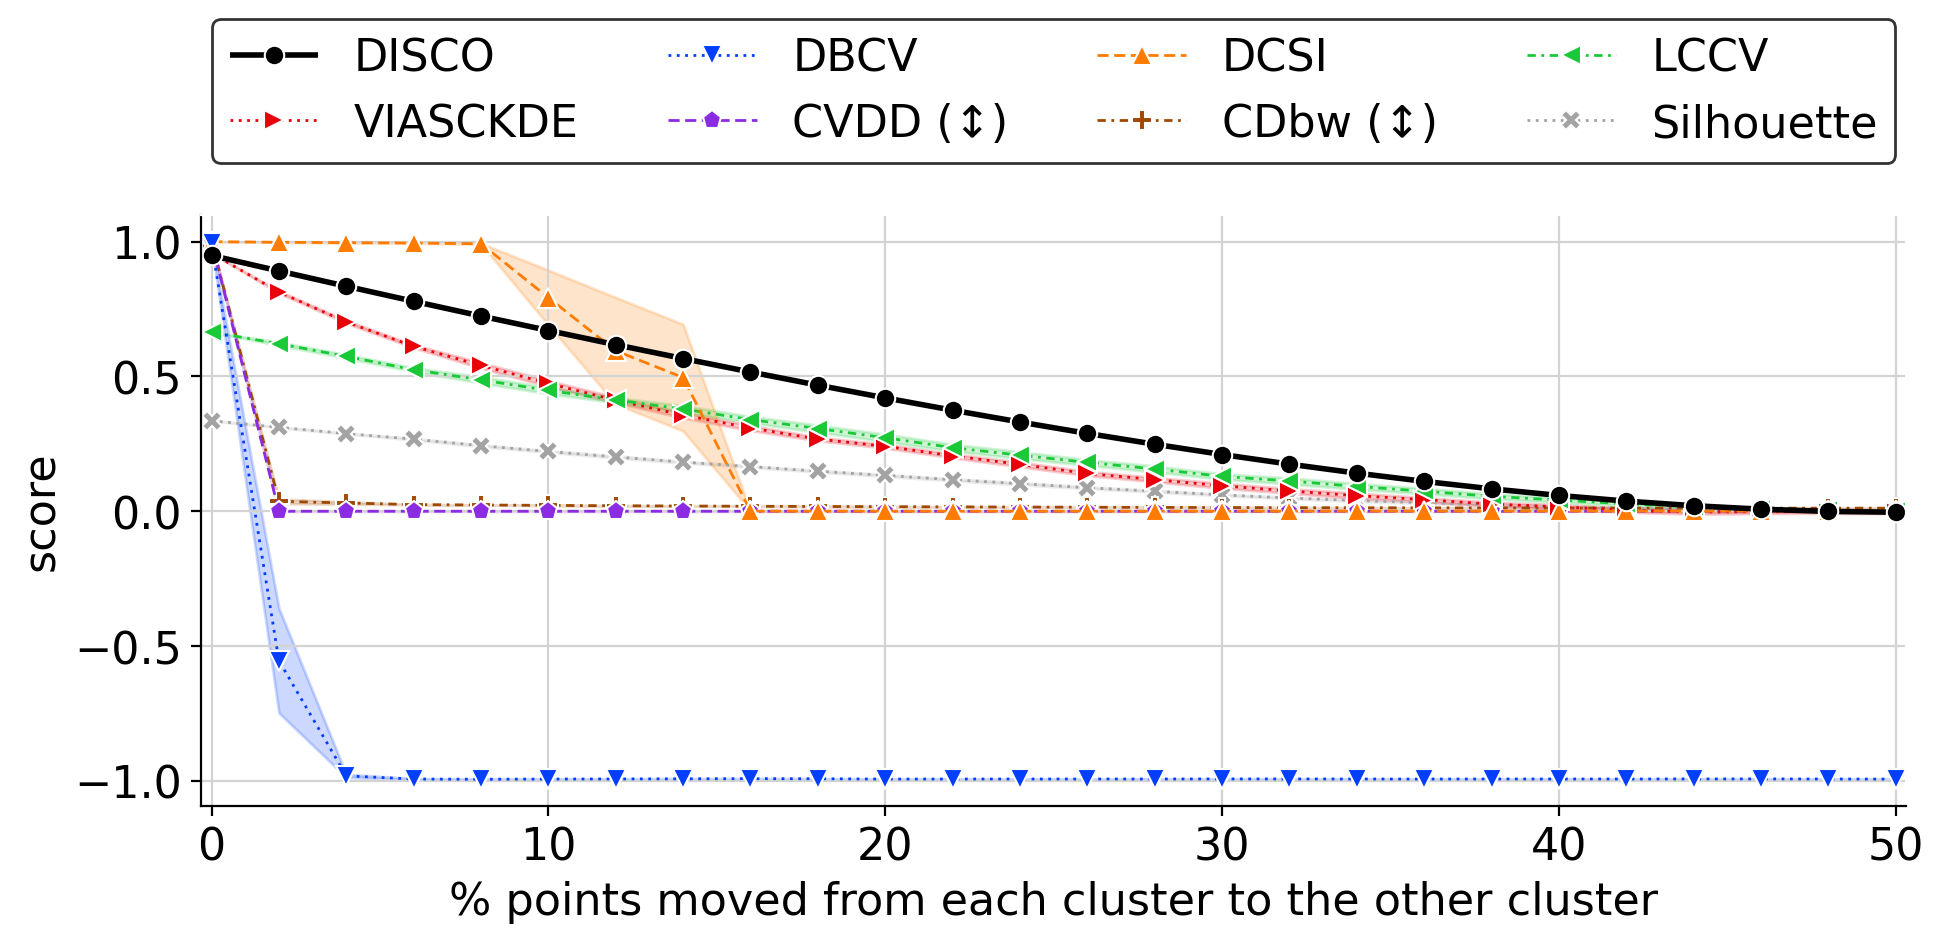

In [10]:
from src.utils.plots import plot_lineplot, GRAY
import seaborn as sns

eps = 0.3
x_range = n_swaps[0] - eps, 2*n_swaps[-1] + eps
df["dataset"] = df["dataset"] * 2

plot_lineplot(
    df,
    "dataset",
    "value",
    "measure",
    y_label="score",
    x_label="% points moved from each cluster to the other cluster",
    x_range=x_range,
    figsize=(10,5),
    palette=["black"] + sns.color_palette("bright")[:6] + [GRAY],
)
plt.savefig("imgs/TwoMoons_nswap.pdf", format="pdf", bbox_inches="tight", pad_inches=0)